## Спортивный анализ данных. Платформа Kaggle
### Тюнинг гиперпараметров, построение ансамблей алгоритмов.

### Практическое задание 6.

* __Задание 1:__ Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

* __Задание 2:__ Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

* __Задание 3:__ Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

* __Задание 4:__ Выполнить задание 2 для трех моделей.
* __Задание 5:__ (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

* __Задание 6:__ (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

https://www.kaggle.com/c/geekbrains-competitive-data-analysis/overview

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats.mstats import gmean

import shap

from pprint import pprint
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Пути к директориям и файлам.

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/Kaggle/project/'

TRAIN_DATASET_PATH = PATH + 'train.csv.zip'
TEST_DATASET_PATH = PATH + 'test.csv.zip'

APPLICATIONS_PATH = PATH + 'applications_history.csv.zip'
CLIENT_PATH = PATH + 'client_profile.csv.zip'
PAYMENTS_PATH = PATH + 'payments.csv.zip'
BKI_PATH = PATH + 'bki.csv.zip'

SAMPLE_PATH = PATH + 'sample_submit.csv.zip'

### 2. Загрузка данных <a name = 'load_data'></a>

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
print('train.shape', train.shape)
train.head(2)

train.shape (110093, 3)


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [5]:
TARGET_NAME = 'TARGET'

In [6]:
test = pd.read_csv(TEST_DATASET_PATH)
print('test.shape', test.shape)
test.head(2)

test.shape (165141, 2)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash


In [7]:
clients = pd.read_csv(CLIENT_PATH)
print('clients', clients.shape)
clients.head(2)

clients (250000, 24)


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
applications = pd.read_csv(APPLICATIONS_PATH)
print('applications', applications.shape)
applications.head(2)

applications (1670214, 26)


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [9]:
bki = pd.read_csv(BKI_PATH)
print('bki', bki.shape)
bki.head(2)

bki (945234, 17)


,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [10]:
payments = pd.read_csv(PAYMENTS_PATH)
print('payments', payments.shape)
payments.head(2)

payments (1023932, 8)


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645


### 3. Формирование базы данных

#### Разделение признаков на количественные и категориальные

In [11]:
def feature_classification(data):
    CATEGORICAL_FEATURE_NAMES = data.dtypes[data.dtypes == "object"].index.tolist()
    NUMERICAL_FEATURE_NAMES = [i for i in data.columns if i not in CATEGORICAL_FEATURE_NAMES]
    NUMERICAL_FEATURE_NAMES.remove(TARGET_NAME)
    
    return NUMERICAL_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES

#### Добавление к данным частот категориальных признаков

In [12]:
def get_frequencies(data, encode_list):
    NEW_FEATURES_FREQUENCIES = []
    for feature in encode_list:        
        new_name = feature + '_freq'
        NEW_FEATURES_FREQUENCIES.append(new_name)
        
        a = data[feature].value_counts()
        if feature == 'BUREAU_ID':
            for i in range(1, 15):
                ind = a[a.values == i].keys().astype(int)
                data.loc[data[feature].isin(ind), new_name] = len(ind)
            ind_ = a[a.values >= 15].keys().astype(int)
            data.loc[data[feature].isin(ind_), new_name] = len(ind)
        elif feature == 'APPLICATION_NUMBER':
            for i in range(1, 20):
                ind = a[a.values == i].keys().astype(int)
                data.loc[data[feature].isin(ind), new_name] = len(ind)
            ind_ = a[a.values >= 20].keys().astype(int)
            data.loc[data[feature].isin(ind_), new_name] = len(ind)
        else:
            for key in a.keys():    
                data.loc[data[feature] == key, new_name] = a[key]
        
            
    return data, NEW_FEATURES_FREQUENCIES

#### Обработка категориальных признаков для LightGBM API

In [13]:
def ordinal_encoding_lgb(data, encode_list):
    CATEGORICAL_FEATURE_NAMES_lgb = []
    for feature in encode_list:
        lgb_feature = feature + '_lgb'
        CATEGORICAL_FEATURE_NAMES_lgb.append(lgb_feature)
        
        for ind, level in enumerate(data[feature].unique()):
            data.loc[data[feature] == level, lgb_feature] = ind
            
    return data, CATEGORICAL_FEATURE_NAMES_lgb

#### clients

In [14]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["EXTERNAL_SCORING_RATING_1"] *\
                                 X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["external_scoring_weighted"] = X.EXTERNAL_SCORING_RATING_1 * 2 +\
                                     X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["ratio_annuity_to_salary"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['ratio_credit_to_salary'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    X["total_salary_net"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["ratio_credit_to_age"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["ratio_salary_to_age"] = X["TOTAL_SALARY"] / X["AGE"]
    X["ratio_salary_to_experience"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_credit_to_experience"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_annuity_to_experience"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["product_salary_and_region_population"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["ratio_car_to_experience"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_car_to_age"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["expected_monthly_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]    
    
    X['NAME_CONTRACT_TYPE'] = np.where(X['NAME_CONTRACT_TYPE'] == 'Cash', 0, 1)
    
    # Композитные признаки
    X['GENDER'] = np.where(X['GENDER'] == 'F', 0, 1)
    X['EDUCATION_LEVEL'] = np.where(X['EDUCATION_LEVEL'].isin(['Higher education', 
                                                               'Academic degree']), 1, 0)
    X['FAMILY_STATUS'] = np.where(X['FAMILY_STATUS'].isin(['Married', 'Widow']), 1, 0)
    X['FAMILY_SIZE'] = np.where(X['FAMILY_SIZE'].isin([1, 2]), 0, 1)    
    X['AMT_REQ_CREDIT_BUREAU_MON'] = np.where(X['AMT_REQ_CREDIT_BUREAU_MON'] == 0, 0, 1)
    X['AMT_REQ_CREDIT_BUREAU_QRT'] = np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] == 0, 0, 1) 
    X['CHILDRENS'] = np.where(X['CHILDRENS'] == 0, 0, 1)
    
    X.loc[:, 'gender_education'] = X.loc[:, ['GENDER', 'EDUCATION_LEVEL']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'family_status_size'] = X.loc[:, ['FAMILY_STATUS', 'FAMILY_SIZE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)    
    X.loc[:, 'AMT_REQ_CREDIT_BUREAU_mon_qtr'] = X.loc[:, ['AMT_REQ_CREDIT_BUREAU_MON', 
                                                          'AMT_REQ_CREDIT_BUREAU_QRT']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'children_phone'] = X.loc[:, ['CHILDRENS', 'FLAG_PHONE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    
    X.drop(['GENDER', 'EDUCATION_LEVEL',
            'FAMILY_STATUS', 'FAMILY_SIZE',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
            'CHILDRENS', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1, inplace=True)
    
    return X

In [15]:
df = pd.concat([train, test], axis=0)
data = pd.merge(df, clients, how='left', on='APPLICATION_NUMBER')
data = create_client_profile_features(data)

NUMERICAL_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES = feature_classification(data)
 
data, NEW_FEATURES_FREQUENCIES = get_frequencies(data, CATEGORICAL_FEATURE_NAMES)
NUMERICAL_FEATURE_NAMES += NEW_FEATURES_FREQUENCIES

data, CATEGORICAL_FEATURE_NAMES_lgb = ordinal_encoding_lgb(data, CATEGORICAL_FEATURE_NAMES)

data.shape

(275234, 58)

#### bki

In [16]:
data_bki = pd.merge(df, bki[~(bki['CREDIT_ACTIVE'] == 'Closed')], 
                    how='left', on = 'APPLICATION_NUMBER')

NUMERICAL_FEATURE_NAMES_bki, CATEGORICAL_FEATURE_NAMES_bki = feature_classification(data_bki)
CATEGORICAL_FEATURE_NAMES_bki = ['BUREAU_ID'] + CATEGORICAL_FEATURE_NAMES_bki[1:]
NUMERICAL_FEATURE_NAMES_bki = NUMERICAL_FEATURE_NAMES_bki[2:]

data_bki, NEW_FEATURES_FREQUENCIES = get_frequencies(data_bki, CATEGORICAL_FEATURE_NAMES_bki)
NUMERICAL_FEATURE_NAMES_bki += NEW_FEATURES_FREQUENCIES

df1 = data_bki[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_bki].groupby('APPLICATION_NUMBER').median()
df2 = data_bki[['APPLICATION_NUMBER'] + CATEGORICAL_FEATURE_NAMES_bki].groupby('APPLICATION_NUMBER').count()
data_bki = pd.concat([df1, df2], axis=1).reset_index()

data_bki.shape

(275234, 21)

#### applications

In [17]:
def create_applications_features(X):
    X['PREV_APPLICATION_NUMBER'] = np.where(X['PREV_APPLICATION_NUMBER'].isnull(), 0, 1)
    X['NAME_GOODS_CATEGORY'] = np.where(X['NAME_GOODS_CATEGORY'] == 'XNA', 1, 0)
    
    return X

In [18]:
data_applications = pd.merge(df, applications, how='left', 
                             on = ['APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE'])
data_applications = create_applications_features(data_applications)
NUMERICAL_FEATURE_NAMES_app, CATEGORICAL_FEATURE_NAMES_app = feature_classification(data_applications)
CATEGORICAL_FEATURE_NAMES_app = CATEGORICAL_FEATURE_NAMES_app[1:]
NUMERICAL_FEATURE_NAMES_app = NUMERICAL_FEATURE_NAMES_app[1:]

data_applications, NEW_FEATURES_FREQUENCIES = get_frequencies(data_applications, CATEGORICAL_FEATURE_NAMES_app)
NUMERICAL_FEATURE_NAMES_app += NEW_FEATURES_FREQUENCIES

df1 = data_applications[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_app].\
                                                groupby('APPLICATION_NUMBER').median()
df2 = data_applications[['APPLICATION_NUMBER'] + CATEGORICAL_FEATURE_NAMES_app].\
                                                 groupby('APPLICATION_NUMBER').count()
data_applications = pd.concat([df1, df2], axis=1).reset_index()

data_applications.shape

(275234, 33)

#### payments

In [19]:
data_payments = pd.merge(df, payments, how='left', on = 'APPLICATION_NUMBER')

NUMERICAL_FEATURE_NAMES_pmt, CATEGORICAL_FEATURE_NAMES_pmt = feature_classification(data_payments)
NUMERICAL_FEATURE_NAMES_pmt = NUMERICAL_FEATURE_NAMES_pmt[2:]
CATEGORICAL_FEATURE_NAMES_pmt = []

data_payments, NEW_FEATURES_FREQUENCIES = get_frequencies(data_payments, ['APPLICATION_NUMBER'])
NUMERICAL_FEATURE_NAMES_pmt += NEW_FEATURES_FREQUENCIES

data_payments = data_payments[['APPLICATION_NUMBER'] + NUMERICAL_FEATURE_NAMES_pmt].\
                                                  groupby('APPLICATION_NUMBER').median()
data_payments.shape

(275234, 7)

#### Формирование единой базы

In [20]:
data = pd.merge(data, data_bki, how='left', on = 'APPLICATION_NUMBER')
data = pd.merge(data, data_applications, how='left', on = 'APPLICATION_NUMBER')
data = pd.merge(data, data_payments, how='left', on = 'APPLICATION_NUMBER')

new_names = ['AMOUNT_CREDIT_x', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_x', 'AMOUNT_ANNUITY_y'] +\
            NUMERICAL_FEATURE_NAMES_bki + NUMERICAL_FEATURE_NAMES_app + NUMERICAL_FEATURE_NAMES_pmt +\
            CATEGORICAL_FEATURE_NAMES_bki + CATEGORICAL_FEATURE_NAMES_app + CATEGORICAL_FEATURE_NAMES_pmt
NUMERICAL_FEATURE_NAMES += new_names
NUMERICAL_FEATURE_NAMES = [i for i in NUMERICAL_FEATURE_NAMES if i in data.columns]

data.shape

(275234, 117)

#### Разделение на обучающую и тестовую выборку

In [21]:
mask = data[TARGET_NAME].isnull()
train, test = data.loc[~mask], data.loc[mask]

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

test = test.replace(np.inf, np.nan)
test = test.replace(-np.inf, np.nan)

### 4. Сохранение / загрузка обработанных данных:

In [22]:
train.to_pickle(PATH + 'train.pkl')
test.to_pickle(PATH + 'test.pkl')

#train = pd.read_pickle(PATH + 'train.pkl')
#test = pd.read_pickle(PATH + 'test.pkl')

In [23]:
#TARGET_NAME = 'TARGET'
#CATEGORICAL_FEATURE_NAMES = train.dtypes[train.dtypes == "object"].index.tolist() + ['BUREAU_ID']
#CATEGORICAL_FEATURE_NAMES_lgb = [i for i in train.columns if i[-4:] == '_lgb']
#exclude_list = CATEGORICAL_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES_lgb + [TARGET_NAME, 'APPLICATION_NUMBER']
#NUMERICAL_FEATURE_NAMES = [i for i in train.columns if i not in exclude_list]

### 5. Добавление к данным признаков на основе WOE

 #### WOE_bin_splits 

In [24]:
bin_splits = dict()
for name in ['numeric', 'categorical']:
    bin_splits[name] = dict()

bin_splits['numeric'] = {
    # clients
    'EXTERNAL_SCORING_RATING_1': [-1, 0.1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'EXTERNAL_SCORING_RATING_2': [-1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'EXTERNAL_SCORING_RATING_3': [-1, 0.2, 0.3, 0.45, 0.6, 0.7, 1],
    'AGE': [7488, 11000, 13000, 15000, 18000, 21000, 25230],
    'OWN_CAR_AGE': [-1, 10, 45, 70],    
    'DAYS_ON_LAST_JOB': [-1, 450, 1500, 2400, 15000, 365244],    
    'REGION_POPULATION': [0, 0.008, 0.012, 0.026, 0.032, 0.073], 
    'AMOUNT_CREDIT_x': [45000, 2.3e+05, 3.4e+05, 5e+05, 7e+05, 1e+06, 4.05e+06],
    'TOTAL_SALARY': [25650, 1.8e+05, 2.3e+05, 5e+06],
    'AMOUNT_ANNUITY_x': [1615.5, 1.3e+04, 2e+04, 2.5e+04, 3.6e+04, 4.8e+04, 230162],
    'AMT_REQ_CREDIT_BUREAU_YEAR': [0, 2, 4, 25],
    
    # bki
    'DAYS_CREDIT_ENDDATE': [0, 100, 5e+04],
    'DAYS_ENDDATE_FACT': [-1, 500, 3000],
    'AMT_CREDIT_SUM': [-1, 5e+04, 4e+05,  4e+08],
    'AMT_CREDIT_SUM_LIMIT': [-1, 1, 3e+06],
    'DAYS_CREDIT_UPDATE': [-1, 30, 240, 700, 5e+04],
    'AMT_CREDIT_MAX_OVERDUE': [-1, 1, 1.5e+07],
    'AMT_CREDIT_SUM_DEBT': [-1, 1, 4.5e+07],
    'DAYS_CREDIT': [-1, 360, 3000],
    'AMT_CREDIT_SUM_OVERDUE': [-1, 1, 1.1e+06],
    'AMT_ANNUITY': [-1, 1, 2e+06, 6e+07],
    
    # applications 
    'AMOUNT_ANNUITY_y': [-1, 2e+04, 5e+05],
    'AMOUNT_CREDIT_y': [-1, 1, 1e+05, 3e+05, 1e+06, 1e+08],    
    'AMOUNT_GOODS_PAYMENT': [-1, 1e+05, 2e+05, 3e+05, 8e+05, 5e+06],    
    'DAYS_DECISION': [-1, 300, 600, 3000],        
    'CNT_PAYMENT': [0, 6, 12, 24, 36, 84],    
    
    'DAYS_FIRST_DUE': [-1, 500, 365242, 365244],
    'DAYS_LAST_DUE_1ST_VERSION': [-1, 180, 500, 900, 365242, 365244],
    'DAYS_LAST_DUE': [-1, 500,  365242, 365244],
    'DAYS_TERMINATION': [-1, 300, 600, 365242, 365244],
    
    #payments
    'NUM_INSTALMENT_VERSION': [0, 3, 45],
    'NUM_INSTALMENT_NUMBER': [-1, 3, 18, 255],
    'DAYS_INSTALMENT': [-1, 300, 600, 1000, 1800, 3000],
    'DAYS_ENTRY_PAYMENT': [-1, 300, 600, 1000, 3100],
    'AMT_INSTALMENT': [0, 50, 200, 2.5e+06],    
    'AMT_PAYMENT': [-1, 1e+03, 8e+03, 1e+04, 2.5e+06],    
}

bin_splits['categorical'] = {
    # clients
    'gender_education': ['0 0', '1 0', '0 1', '1 1'],
    'family_status_size': ['1 0', '0 0', '0 1', '1 1'],
    'AMT_REQ_CREDIT_BUREAU_mon_qtr': ['0 0', '1 1', '0 1', '1 0'],
    'children_phone': ['0. 0.', '1. 0.', '0. 1.', '1. 1.'],
    
    # bki
    'CREDIT_ACTIVE': ['Active'],
    
    # applications    
    'NAME_CONTRACT_STATUS': ['Approved', 'Canceled', 'Refused'],
    'NAME_PAYMENT_TYPE': ['Cash through the bank', 'XNA'],
    'CODE_REJECT_REASON': ['XAP', 'HC'],
    'NAME_TYPE_SUITE': ['Unaccompanied', 'Family'],
    'NAME_CLIENT_TYPE': ['Repeater', 'Refreshed'],    
    'NAME_PORTFOLIO': ['Cash', 'XNA', 'Cards'],
    'NAME_PRODUCT_TYPE': ['x-sell', 'XNA', 'walk-in'],
    'NAME_YIELD_GROUP': ['XNA', 'middle', 'low_normal', 'high', 'low_action'],
}

In [25]:
class WOEFeatures:
    def __init__(self, CATEGORICAL_FEATURE_NAMES, bin_splits):        
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES            
        self.bin_split_numeric = bin_splits['numeric']
        self.bin_split_categorical = bin_splits['categorical']      
        
        self.WOE = {}
        self.NEW_VARIABLE_NAMES = []        
        
   
    def WOE_formula(self, a, epsilon=1e-04):
        a = a.mean()
        if a == 1.0:
            a -= epsilon
        elif a == 0:
            a += epsilon

        return np.log(a / (1 - a))
    
    
    def WOE_calc_numeric(self, df, feature): 
        bin_split = self.bin_split_numeric[feature]
        feature_dict = {}
        for i in range(1, len(bin_split)):        
            cond_1 = df[feature] >= bin_split[i - 1]
            cond_2 = df[feature] < bin_split[i]
            a = df.loc[(cond_1 & cond_2), TARGET_NAME]
             
            feature_dict[bin_split[i]] = self.WOE_formula(a)
        
        return  feature_dict        
        

    def calc_a(self, df, sub_category):        
        cond = df[feature] == sub_category[0]
        for j in range(1, len(sub_category)):
            cond |= (df[feature] == sub_category[j])        
        a = df.loc[cond, TARGET_NAME]    
        return a
    

    def WOE_calc_categorical(self, df, feature):
        bin_split = self.bin_split_categorical[feature]
        feature_dict = {}
        for i in range(len(bin_split)):
            sub_category = bin_split[i]
            if isinstance(sub_category, list):                
                a = self.calc_a(feature, sub_category) 
            else:
                a = df.loc[df[feature] == sub_category, TARGET_NAME]
            WOE_ = self.WOE_formula(a)       

            if isinstance(sub_category, list):
                for item in sub_category:
                    feature_dict[item] = WOE_
            else:
                feature_dict[sub_category] = WOE_
        
        return feature_dict    
    
     
    def fit_fransform(self, X, y=None):
        df = X.copy()
        
        if y is not None:
            df[TARGET_NAME] = y.values             
            
            for feature in self.bin_split_numeric.keys():             
                self.WOE[feature] = self.WOE_calc_numeric(df, feature) 
                self.NEW_VARIABLE_NAMES.append(feature + '_')
                
            for feature in self.bin_split_categorical.keys():
                self.WOE[feature] = self.WOE_calc_categorical(df, feature)
                self.NEW_VARIABLE_NAMES.append(feature + '_')  


        for feature in self.bin_split_numeric.keys():
            new_feature = feature + '_' 
            feature_list = self.bin_split_numeric[feature]
            for i in range(1, len(feature_list)):
                cond_1 = X[feature] >= feature_list[i - 1]
                cond_2 = X[feature] < feature_list[i]
                X.loc[(cond_1 & cond_2), new_feature] = self.WOE[feature][feature_list[i]]
                
        if self.bin_split_categorical.keys():
            for feature in self.bin_split_categorical.keys():
                new_feature = feature + '_'            
                feature_list = self.WOE[feature]
                for item in feature_list:        
                    X.loc[X[feature] == item, new_feature] = self.WOE[feature][item]
        
                  
        return X

#### Генерация WOE признаков для тестовой выборки

In [26]:
features_ = [i for i in train.columns if i != TARGET_NAME]

WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
train_final = WOE_features.fit_fransform(train[features_], train[TARGET_NAME])
test_final = WOE_features.fit_fransform(test[features_])

### 6. Train-test split

In [27]:
def applications_split(i, target=0):
    random.seed(i)    
    appl_n = train.loc[train[TARGET_NAME] == target, 'APPLICATION_NUMBER'].unique()
    
    train_list = random.sample(list(appl_n), int(len(appl_n) * 0.7))                         
    valid_list = random.sample(list(set(appl_n) - set(train_list)) , int(len(appl_n) * 0.2))
    test_list = list(set(appl_n) - set(train_list) - set(valid_list))
    
    return train_list, valid_list, test_list


def train_test_ind(i, no_valid):
    train_list_0, valid_list_0, test_list_0 = applications_split(i, 0)
    train_list_1, valid_list_1, test_list_1, = applications_split(i, 1)
    
    train_list = train_list_0 + train_list_1
    valid_list = valid_list_0 + valid_list_1
    test_list = test_list_0 + test_list_1
    
    if no_valid:
        test_list += valid_list
        ind_train = train[train['APPLICATION_NUMBER'].isin(train_list)].index
        ind_test = train[train['APPLICATION_NUMBER'].isin(test_list)].index
        
        return ind_train, ind_test
    
    ind_train = train[train['APPLICATION_NUMBER'].isin(train_list)].index
    ind_valid = train[train['APPLICATION_NUMBER'].isin(valid_list)].index
    ind_test = train[train['APPLICATION_NUMBER'].isin(test_list)].index
    
    return ind_train, ind_valid, ind_test


def train_test_split(i, no_valid=0):
    
    if no_valid:
        ind_train, ind_test = train_test_ind(i, no_valid)        
        df_train = train.loc[ind_train]
        df_test = train.loc[ind_test]
        y_train = df_train[TARGET_NAME]
        y_test = df_test[TARGET_NAME]
        
        WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
        df_train = WOE_features.fit_fransform(df_train[features_], df_train[TARGET_NAME])
        df_test = WOE_features.fit_fransform(df_test[features_])
        
        return df_train, df_test, y_train, y_test
    
    ind_train, ind_valid, ind_test = train_test_ind(i, no_valid)
    df_train = train.loc[ind_train]
    df_valid = train.loc[ind_valid]
    df_test = train.loc[ind_test]

    y_train = df_train[TARGET_NAME]
    y_valid = df_valid[TARGET_NAME]
    y_test = df_test[TARGET_NAME]

    WOE_features = WOEFeatures(CATEGORICAL_FEATURE_NAMES, bin_splits)
    df_train = WOE_features.fit_fransform(df_train[features_], df_train[TARGET_NAME])
    df_valid = WOE_features.fit_fransform(df_valid[features_])
    df_test = WOE_features.fit_fransform(df_test[features_])    

    return df_train, df_valid, df_test,  y_train, y_valid, y_test

### 7. Модели

#### XGBoost

In [28]:
def run_model_xgb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=y_train)
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid)
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES], label=y_test)
    
    params_xgb = {"booster": "gbtree", 
                  "objective": "binary:logistic", 
                  "eval_metric": "auc", 
                  "learning_rate": 0.05,  
                  "reg_lambda": 100, 
                  "max_depth": 4, 
                  "gamma": 10, 
                  "nthread": 6, 
                  "seed": 27}

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
                          verbose_eval=50,
                          maximize=True)
    
    return model_xgb

#### LightGBM

In [29]:
def run_model_lgb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    
    dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES], label=y_train,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid,
                         categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    dtest = lgb.Dataset(data=df_test[SELECTED_FEATURE_NAMES], label=y_test,
                        categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb)
    
    params_lgb = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,  
                  "learning_rate": 0.01,
                  "class_weight": 'balanced',
                  "max_depth": 4,
                  "n_estimators": 5000,
                  "n_jobs": 6,
                  "seed": 27} 

    model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid, dtest],
                          categorical_feature=CATEGORICAL_FEATURE_NAMES_lgb, 
                          verbose_eval=100,
                          early_stopping_rounds=50)
    
    return model_lgb

#### CatBoost

In [30]:
def run_model_cb(SELECTED_FEATURE_NAMES, i):
    df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
    
    
    dtrain = Pool(data=df_train[SELECTED_FEATURE_NAMES], label=y_train,
                         cat_features=CATEGORICAL_FEATURE_NAMES)
    dvalid = Pool(data=df_valid[SELECTED_FEATURE_NAMES], label=y_valid,
                         cat_features=CATEGORICAL_FEATURE_NAMES)
    dtest = Pool(data=df_test[SELECTED_FEATURE_NAMES], label=y_test,
                        cat_features=CATEGORICAL_FEATURE_NAMES)
    
    params_cb = {"n_estimators":5000,
                 "loss_function": "Logloss",
                 "eval_metric": "AUC",
                 "task_type": "CPU",
                 "max_bin": 30,
                 "early_stopping_rounds": 50,
                 "verbose": 100,
                 "max_depth": 5,
                 "l2_leaf_reg": 80, 
                 "thread_count": 6,
                 "random_seed": 42}

    model_cb = CatBoostClassifier(**params_cb)
    model_cb.fit(dtrain, eval_set=[dvalid, dtest])
    
    return model_cb

#### Random Forest

In [31]:
def run_model_rf(SELECTED_FEATURE_NAMES, i):
    df_train, df_test, y_train, y_test = train_test_split(i, 1)
    
    params_rf = {"n_estimators": 300,
                 "max_depth": 6,
                 "class_weight": 'balanced_subsample',                 
                 "random_state": 42}

    model_rf = RandomForestClassifier(**params_rf)
    model_rf.fit(df_train[SELECTED_FEATURE_NAMES].fillna(-99), y_train)
    
    y_train_pred = model_rf.predict(df_train[SELECTED_FEATURE_NAMES].fillna(-99))
    y_test_pred = model_rf.predict(df_test[SELECTED_FEATURE_NAMES].fillna(-99))
    
    print('roc_auc_score train =', roc_auc_score(y_train, y_train_pred))
    print('roc_auc_score test =', roc_auc_score(y_test, y_test_pred))
    
    return model_rf

### 8. Отбор признаков

In [32]:
SELECTED_FEATURE_NAMES_xgb = NUMERICAL_FEATURE_NAMES + WOE_features.NEW_VARIABLE_NAMES
SELECTED_FEATURE_NAMES_lgb = SELECTED_FEATURE_NAMES_xgb + CATEGORICAL_FEATURE_NAMES_lgb 
SELECTED_FEATURE_NAMES_cb = SELECTED_FEATURE_NAMES_xgb + CATEGORICAL_FEATURE_NAMES
SELECTED_FEATURE_NAMES_rf = SELECTED_FEATURE_NAMES_xgb

#### Base model XGBoost

In [33]:
i = 42
model_xgb = run_model_xgb(SELECTED_FEATURE_NAMES_xgb, i)
#[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115

[0]	train-auc:0.60304	valid-auc:0.60438	test-auc:0.60028
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70753	valid-auc:0.69755	test-auc:0.68609
[100]	train-auc:0.72740	valid-auc:0.71642	test-auc:0.70133
[150]	train-auc:0.73573	valid-auc:0.72218	test-auc:0.70991
[200]	train-auc:0.73686	valid-auc:0.72321	test-auc:0.71103
Stopping. Best iteration:
[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115



In [34]:
df_train, df_valid, df_test, y_train, y_valid, y_test = train_test_split(i)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_xgb], y_valid)

In [35]:
shap_importances = pd.DataFrame(shap_values.mean(axis=0), SELECTED_FEATURE_NAMES_xgb, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 0].index.tolist()
len(features)

53

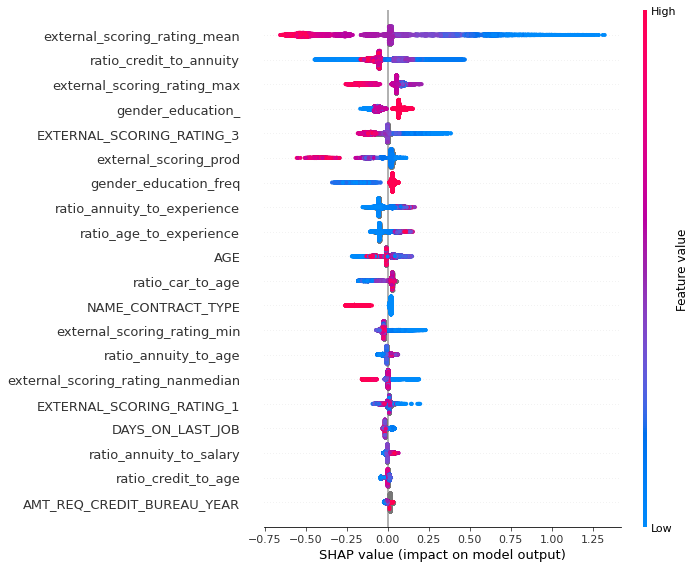

In [36]:
shap.summary_plot(shap_values, df_valid[SELECTED_FEATURE_NAMES_xgb])

In [37]:
model_xgb = run_model_xgb(features, i)
# [158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115

[0]	train-auc:0.60304	valid-auc:0.60438	test-auc:0.60028
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.70753	valid-auc:0.69755	test-auc:0.68609
[100]	train-auc:0.72740	valid-auc:0.71642	test-auc:0.70133
[150]	train-auc:0.73573	valid-auc:0.72218	test-auc:0.70991
[200]	train-auc:0.73686	valid-auc:0.72321	test-auc:0.71103
Stopping. Best iteration:
[158]	train-auc:0.73648	valid-auc:0.72261	test-auc:0.71115



In [38]:
SELECTED_FEATURE_NAMES_xgb = features

#### Base model LightGBM

In [39]:
model_lgb = run_model_lgb(SELECTED_FEATURE_NAMES_lgb, i)
#[671]	training's auc: 0.765193	valid_1's auc: 0.725737	valid_2's auc: 0.713897

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.719541	valid_1's auc: 0.706359	valid_2's auc: 0.693098
[200]	training's auc: 0.729472	valid_1's auc: 0.713504	valid_2's auc: 0.698455
[300]	training's auc: 0.740197	valid_1's auc: 0.719792	valid_2's auc: 0.704773
[400]	training's auc: 0.748134	valid_1's auc: 0.722551	valid_2's auc: 0.709719
[500]	training's auc: 0.755425	valid_1's auc: 0.724312	valid_2's auc: 0.711888
[600]	training's auc: 0.761503	valid_1's auc: 0.725006	valid_2's auc: 0.713357
[700]	training's auc: 0.766549	valid_1's auc: 0.725571	valid_2's auc: 0.714301
Early stopping, best iteration is:
[671]	training's auc: 0.765193	valid_1's auc: 0.725737	valid_2's auc: 0.713897


In [40]:
SELECTED_FEATURE_NAMES_lgb = NUMERICAL_FEATURE_NAMES + WOE_features.NEW_VARIABLE_NAMES + CATEGORICAL_FEATURE_NAMES_lgb 

In [41]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_lgb], y_valid)

In [42]:
shap_importances = pd.DataFrame(shap_values[1].mean(axis=0), SELECTED_FEATURE_NAMES_lgb, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 5e-06].index.tolist()
len(features)

101

In [43]:
CATEGORICAL_FEATURE_NAMES_lgb = [i for i in features if i in CATEGORICAL_FEATURE_NAMES_lgb]

In [44]:
model_lgb = run_model_lgb(features, i)
#[708]	training's auc: 0.767096	valid_1's auc: 0.726251	valid_2's auc: 0.715608

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.719761	valid_1's auc: 0.706462	valid_2's auc: 0.692973
[200]	training's auc: 0.729411	valid_1's auc: 0.713513	valid_2's auc: 0.698704
[300]	training's auc: 0.740177	valid_1's auc: 0.719645	valid_2's auc: 0.704514
[400]	training's auc: 0.748164	valid_1's auc: 0.722573	valid_2's auc: 0.710341
[500]	training's auc: 0.755117	valid_1's auc: 0.724241	valid_2's auc: 0.712563
[600]	training's auc: 0.761253	valid_1's auc: 0.725653	valid_2's auc: 0.714005
[700]	training's auc: 0.766663	valid_1's auc: 0.726298	valid_2's auc: 0.715331
Early stopping, best iteration is:
[708]	training's auc: 0.767096	valid_1's auc: 0.726251	valid_2's auc: 0.715608


In [45]:
SELECTED_FEATURE_NAMES_lgb = features

#### Base model Catboost

In [46]:
model_cb = run_model_cb(SELECTED_FEATURE_NAMES_cb, i)
# bestTest = 0.7118630863
# bestIteration = 613

0:	test: 0.6159018	test1: 0.6104511	best: 0.6104511 (0)	total: 908ms	remaining: 1h 15m 37s
100:	test: 0.7129756	test1: 0.7002038	best: 0.7002038 (100)	total: 17.8s	remaining: 14m 23s
200:	test: 0.7203491	test1: 0.7075849	best: 0.7075870 (199)	total: 34.7s	remaining: 13m 48s
300:	test: 0.7223720	test1: 0.7091434	best: 0.7092583 (298)	total: 51.2s	remaining: 13m 19s
400:	test: 0.7240360	test1: 0.7102587	best: 0.7102587 (400)	total: 1m 7s	remaining: 12m 50s
500:	test: 0.7245415	test1: 0.7112093	best: 0.7112101 (496)	total: 1m 21s	remaining: 12m 13s
600:	test: 0.7246919	test1: 0.7117751	best: 0.7117777 (595)	total: 1m 35s	remaining: 11m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7118630863
bestIteration = 613

Shrink model to first 614 iterations.


In [47]:
shap_values_cb = model_cb.get_feature_importance(data=Pool(data=df_valid[SELECTED_FEATURE_NAMES_cb],
                                                           label=y_valid, cat_features=CATEGORICAL_FEATURE_NAMES), 
                                                 fstr_type='ShapValues',
                                                 prettified=True)

In [48]:
a = shap_values_cb.mean(axis=0)
features = [SELECTED_FEATURE_NAMES_cb[i] for i in a[abs(a) > 3e-04].index[:-1]]
features = [i for i in features if i not in CATEGORICAL_FEATURE_NAMES] + CATEGORICAL_FEATURE_NAMES
len(features)

75

In [49]:
model_cb = run_model_cb(features, i)
# bestTest = 0.7120212334
# bestIteration = 469

0:	test: 0.6702045	test1: 0.6508507	best: 0.6508507 (0)	total: 166ms	remaining: 13m 48s
100:	test: 0.7126078	test1: 0.6991399	best: 0.6992243 (99)	total: 15.3s	remaining: 12m 21s
200:	test: 0.7205548	test1: 0.7058374	best: 0.7058374 (200)	total: 29.8s	remaining: 11m 50s
300:	test: 0.7233776	test1: 0.7093241	best: 0.7093399 (299)	total: 43.9s	remaining: 11m 25s
400:	test: 0.7247165	test1: 0.7110121	best: 0.7110121 (400)	total: 57.7s	remaining: 11m 1s
500:	test: 0.7258057	test1: 0.7117947	best: 0.7120212 (469)	total: 1m 10s	remaining: 10m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7120212334
bestIteration = 469

Shrink model to first 470 iterations.


In [50]:
SELECTED_FEATURE_NAMES_cb = features

#### Base model Random Forest

In [51]:
model_rf = run_model_rf(SELECTED_FEATURE_NAMES_rf, i)
#roc_auc_score train =0.6678663000119389
#roc_auc_score test = 0.6414066230907469

roc_auc_score train = 0.6678663000119389
roc_auc_score test = 0.6414066230907469


In [52]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES_rf], y_valid)

In [53]:
shap_importances = pd.DataFrame(shap_values[1].mean(axis=0), SELECTED_FEATURE_NAMES_rf, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 1e-05].index.tolist()
len(features)

123

In [54]:
model_rf = run_model_rf(features, i)
# roc_auc_score train = 0.6654171034486742
# roc_auc_score test = 0.6447353289036946 

roc_auc_score train = 0.6654171034486742
roc_auc_score test = 0.6447353289036946


In [55]:
SELECTED_FEATURE_NAMES_rf = features

In [56]:
gc.collect()

136

### 9. Ансамблирование моделей

#### OOF_predictions

In [57]:
OOF_predictions = df_test[['APPLICATION_NUMBER']].set_index('APPLICATION_NUMBER')
OOF_predictions.loc[:, 'y_pred_xgb'] = model_xgb.predict(xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES_xgb]))
OOF_predictions.loc[:, 'y_pred_lgb'] = model_lgb.predict(df_test[SELECTED_FEATURE_NAMES_lgb])
OOF_predictions.loc[:, 'y_pred_cb'] = model_cb.predict_proba(df_test[SELECTED_FEATURE_NAMES_cb])[:, 1]
OOF_predictions.loc[:, 'y_pred_rf'] = model_rf.predict_proba(df_test[SELECTED_FEATURE_NAMES_rf].fillna(-99))[:, 1]

OOF_predictions.corr()

,y_pred_xgb,y_pred_lgb,y_pred_cb,y_pred_rf
y_pred_xgb,1.000000,0.982202,0.975148,0.833801
y_pred_lgb,0.982202,1.000000,0.971372,0.831376
y_pred_cb,0.975148,0.971372,1.000000,0.829686
y_pred_rf,0.833801,0.831376,0.829686,1.000000


#### Прогнозы на тестовой выборке

In [58]:
predictions_test = test[['APPLICATION_NUMBER']].set_index('APPLICATION_NUMBER')
predictions_test.loc[:, 'y_pred_xgb'] = model_xgb.predict(xgb.DMatrix(data=test_final[SELECTED_FEATURE_NAMES_xgb]))
predictions_test.loc[:, 'y_pred_lgb'] = model_lgb.predict(test_final[SELECTED_FEATURE_NAMES_lgb])
predictions_test.loc[:, 'y_pred_cb'] = model_cb.predict_proba(test_final[SELECTED_FEATURE_NAMES_cb])[:, 1]
predictions_test.loc[:, 'y_pred_rf'] = model_rf.predict_proba(test_final[SELECTED_FEATURE_NAMES_rf].fillna(-99))[:, 1]

predictions_test.corr()

,y_pred_xgb,y_pred_lgb,y_pred_cb,y_pred_rf
y_pred_xgb,1.000000,0.981449,0.974998,0.830647
y_pred_lgb,0.981449,1.000000,0.970155,0.825676
y_pred_cb,0.974998,0.970155,1.000000,0.828140
y_pred_rf,0.830647,0.825676,0.828140,1.000000


In [59]:
# арифмитическе среднее
OOF_predictions.loc[:, 'mean_xgb_lgb'] =\
             OOF_predictions[['y_pred_xgb', 'y_pred_lgb']].mean(axis=1).values
OOF_predictions.loc[:, 'mean_xgb_lgb_cb'] =\
             OOF_predictions[['y_pred_xgb', 'y_pred_lgb', 'y_pred_cb']].mean(axis=1).values

# геометриеское среднее
OOF_predictions.loc[:, 'gmean_xgb_lgb'] =\
             gmean(OOF_predictions[['y_pred_xgb', 'y_pred_lgb']],axis=1)
OOF_predictions.loc[:, 'gmean_xgb_lgb_cb'] =\
             gmean(OOF_predictions[['y_pred_xgb', 'y_pred_lgb', 'y_pred_cb']],axis=1)
# усреднение рангов
OOF_predictions.loc[:, 'mean_rank_xgb_lgb'] =\
           OOF_predictions[['y_pred_xgb', 'y_pred_lgb']].rank(axis=0).mean(axis=1).values
OOF_predictions.loc[:, 'mean_rank_xgb_lgb_cb'] =\
           OOF_predictions[['y_pred_xgb', 'y_pred_lgb', 'y_pred_cb']].rank(axis=0).mean(axis=1).values

OOF_predictions.head(2)

,y_pred_xgb,y_pred_lgb,y_pred_cb,y_pred_rf,mean_xgb_lgb,mean_xgb_lgb_cb,gmean_xgb_lgb,gmean_xgb_lgb_cb,mean_rank_xgb_lgb,mean_rank_xgb_lgb_cb
APPLICATION_NUMBER,,,,,,,,,,
123687442,0.020708,0.011368,0.019323,0.164292,0.016038,0.017133,0.015343,0.016569,454.0,585.666667
123525176,0.095009,0.096404,0.105517,0.554316,0.095707,0.098977,0.095704,0.098869,8533.0,8643.333333


#### roc_auc_score

In [60]:
roc_auc = pd.DataFrame()
for y_pred in OOF_predictions.columns:
    roc_auc.loc[y_pred, 'roc_auc_score'] = roc_auc_score(y_test, OOF_predictions[y_pred])
    
roc_auc    

,roc_auc_score
y_pred_xgb,0.711031
y_pred_lgb,0.715608
y_pred_cb,0.712021
y_pred_rf,0.696454
mean_xgb_lgb,0.714145
mean_xgb_lgb_cb,0.714384
gmean_xgb_lgb,0.714058
gmean_xgb_lgb_cb,0.714203
mean_rank_xgb_lgb,0.714305
mean_rank_xgb_lgb_cb,0.714354


#### Логистическая регрессия

In [61]:
model_lr = LogisticRegression().fit(OOF_predictions, y_test)
y_pred = model_lr.predict_proba(OOF_predictions)[:, 1]
roc_auc_score(y_test, y_pred)

0.7158199806585841

### 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

На обучающей выборке корреляция прогнозов LightGBM и XGBoost превышает 0.98. Аналогичная ситуация и на тестовой выборке.

### 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Усреднение хорошо подтягивает относительно слабые модели, но не дотягивается до качества лучших. Среднее арифметическое дает лучший результат, чем среднее геометрическое, но усреднение рангов эффективнее и первого и второго.

### 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Корреляция CatBoost с моделями LightGBM и XGBoost превышает 0.97. Она немнного выше с XGBoost и ниже с LightGBM. Аналогичная ситуация на тестовой выборке. 

### 4. Выполнить задание 2 для трех моделей.

Комбинация трех моделей дает более высокий результат, чем комбинация 2 моделей, но пока не превосходит качество самой сильной модели.

### 5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

Качество, достигаемое при использовании логистиеской регрессии превосходит результаты всех моделей.

### 6. (опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

У алгоритма RandomForest самая низкая корреляция с другими моделями, соответственно он вносит свой вклад в достигнутый результат, несмотря на относительно слабую индивидуальную эффективность.